In [5]:
import numpy as np
import sys
from pathlib import Path

# Add the parent directory of the notebook to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from utils.load import load_feature_matrices, load_metadata, load_feature_matrices_aligned
from scripts.features import save_ctms, save_sequences
from utils.metrics import create_kl_adjacency

In [6]:
import pandas as pd
import pyarrow.parquet as pq
from IPython.display import display

# Read Parquet with PyArrow, ignoring extension types
table = pq.read_table("../data/sequence_dataset.parquet", use_pandas_metadata=True)
df = table.to_pandas()

display(df.head(10))

name  \
0  Star Wars: Rogue Squadron II - Rogue Leader   
1  Star Wars: Rogue Squadron II - Rogue Leader   
2                      Donkey Kong Jungle Beat   
3                      Donkey Kong Jungle Beat   
4                                Viewtiful Joe   
5          Phantasy Star Online Episode I & II   
6                                Poop Killer 7   
7                                Poop Killer 7   
8                                Poop Killer 7   
9                                Poop Killer 7   

                                       note_sequence  \
0  [55, 55, 60, 60, 48, 48, 51, 51, 62, 62, 56, 5...   
1  [59, 38, 47, 47, 59, 47, 47, 38, 59, 47, 38, 4...   
2  [45, 64, 61, 57, 64, 61, 57, 45, 57, 64, 61, 4...   
3  [70, 71, 72, 73, 42, 23, 49, 73, 61, 56, 49, 6...   
4  [33, 33, 75, 81, 33, 36, 36, 36, 38, 38, 59, 3...   
5  [43, 41, 45, 63, 60, 79, 63, 67, 60, 48, 43, 3...   
6  [67, 48, 44, 48, 65, 64, 67, 60, 64, 44, 62, 4...   
7  [48, 60, 60, 72, 36, 84, 84, 86, 86, 59, 71, 3...   
8  [45, 41, 70, 93, 41, 52, 48, 50, 55, 57, 62, 5...   
9  [68, 68, 68, 68, 68, 68, 65, 65, 65, 65, 60, 6...   

                                                 ctm      id rating  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    4181   85.4   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    4181   85.4   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    1097   67.7   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    1097   67.7   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  341259      0   
5  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    9890   73.4   
6  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  251979      0   
7  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  251979      0   
8  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  251979      0   
9  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...  251979      0   

                                     themes  \
0             ["Action", "Science fiction"]   
1             ["Action", "Science fiction"]   
2                                ["Action"]   
3                                ["Action"]   
4                                ["Action"]   
5  ["Action", "Science fiction", "Sandbox"]   
6                      ["Horror", "Comedy"]   
7                      ["Horror", "Comedy"]   
8                      ["Horror", "Comedy"]   
9                      ["Horror", "Comedy"]   

                                            keywords  \
0  ["space simulation", "space combat", "robots",...   
1  ["space simulation", "space combat", "robots",...   
2  ["combat", "pig", "panda", "underwater gamepla...   
3  ["combat", "pig", "panda", "underwater gamepla...   
4                                                 []   
5  ["monsters", "magic", "death", "robots", "clas...   
6                                                 []   
7                                                 []   
8                                                 []   
9                                                 []   

                                  involved_companies first_release_year  
0            ["Activision", "Factor 5", "LucasArts"]               2001  
1            ["Activision", "Factor 5", "LucasArts"]               2001  
2  ["Nintendo EAD Tokyo Software Development Grou...               2004  
3  ["Nintendo EAD Tokyo Software Development Grou...               2004  
4                        ["Clover Studio", "Capcom"]               2004  
5                             ["Sonic Team", "Sega"]               2002  
6                                      ["616 GAMES"]               2023  
7                                      ["616 GAMES"]               2023  
8                                      ["616 GAMES"]               2023  
9                                      ["616 GAMES"]               2023

In [8]:
import pandas as pd
import numpy as np

# -------------------------------------
# Extract CTMs as a real DataFrame
# -------------------------------------
matrices_df = pd.DataFrame()
matrices_df["ctm"] = df["ctm"].apply(lambda x: np.array(x, dtype=np.float64))
matrices_df.index.name = "song_idx"

# -------------------------------------
# Normalize CTMs globally
# -------------------------------------
def normalize_global(M: np.ndarray) -> np.ndarray:
    total = M.sum()
    return M / total if total != 0 else M

matrices_df["ctm"] = matrices_df["ctm"].apply(normalize_global)

# -------------------------------------
# Keep metadata in a separate aligned DataFrame
# -------------------------------------
metadata_df = df.drop(columns=["ctm"]).copy()
metadata_df.index = matrices_df.index

# -------------------------------------
# Check first song
# -------------------------------------
first_song_idx = matrices_df.index[0]
print("First song index:", first_song_idx)
print("Song metadata:", metadata_df.loc[first_song_idx].to_dict())
print("CTM shape:", matrices_df.loc[first_song_idx, "ctm"].shape)

ValueError: setting an array element with a sequence.

In [ ]:
ctms_list = matrices_df['ctm'].tolist()
distance_matrix = create_kl_adjacency(ctms_list)

Computing KL adjacency (unmasked): 100%|██████████| 3320/3320 [37:41<00:00,  1.47it/s]  


### Exploring the data

In [ ]:
import numpy as np

def top_similar_songs_list(distance_matrix: np.ndarray, matrices_df: pd.DataFrame, df: pd.DataFrame, top_k: int = 10):
    """
    Returns the top_k most similar song pairs based on distance of CTMs.

    Args:
        distance_matrix (np.ndarray): n x n matrix of distances.
        matrices_df (pd.DataFrame): DataFrame with 'ctm' column, indexed by song_idx.
        df (pd.DataFrame): Original DataFrame with metadata columns like 'name' and 'game_id', indexed by song_idx.
        top_k (int): Number of top pairs to return.

    Returns:
        List of tuples: [(song1_idx, song2_idx, song1_name, song2_name, distance), ...]
    """
    n = distance_matrix.shape[0]
    triu_idx = np.triu_indices(n, k=1)  # upper triangle indices
    all_pairs = [(i, j, distance_matrix[i, j]) for i, j in zip(*triu_idx)]
    all_pairs.sort(key=lambda x: x[2])  # smallest distance = most similar
    top_pairs = all_pairs[:top_k]

    results = []
    for i, j, dist in top_pairs:
        song1_idx = matrices_df.index[i]
        song2_idx = matrices_df.index[j]
        # Get metadata from original df
        song1_name = df.loc[song1_idx, "name"]
        song2_name = df.loc[song2_idx, "name"]
        results.append((song1_idx, song2_idx, song1_name, song2_name, dist))

    return results

# Usage example:
top_10 = top_similar_songs_list(distance_matrix, matrices_df, df, top_k=10)
for s1, s2, n1, n2, d in top_10:
    print(f"{n1} ({s1}) <-> {n2} ({s2}): distance={d:.2f}")

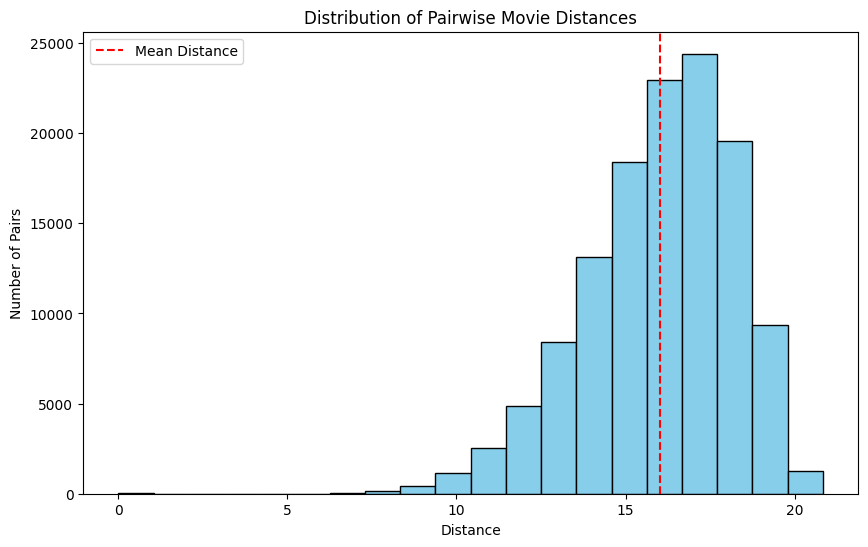

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get upper triangle indices, excluding the diagonal
triu_idx = np.triu_indices(distance_matrix.shape[0], k=1)
all_distances = distance_matrix[triu_idx]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(all_distances, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Pairwise Movie Distances")
plt.xlabel("Distance")
plt.ylabel("Number of Pairs")
plt.axvline(np.mean(all_distances), color='red', linestyle='dashed', label='Mean Distance')
plt.legend()
plt.show()

Top 2 most similar songs:


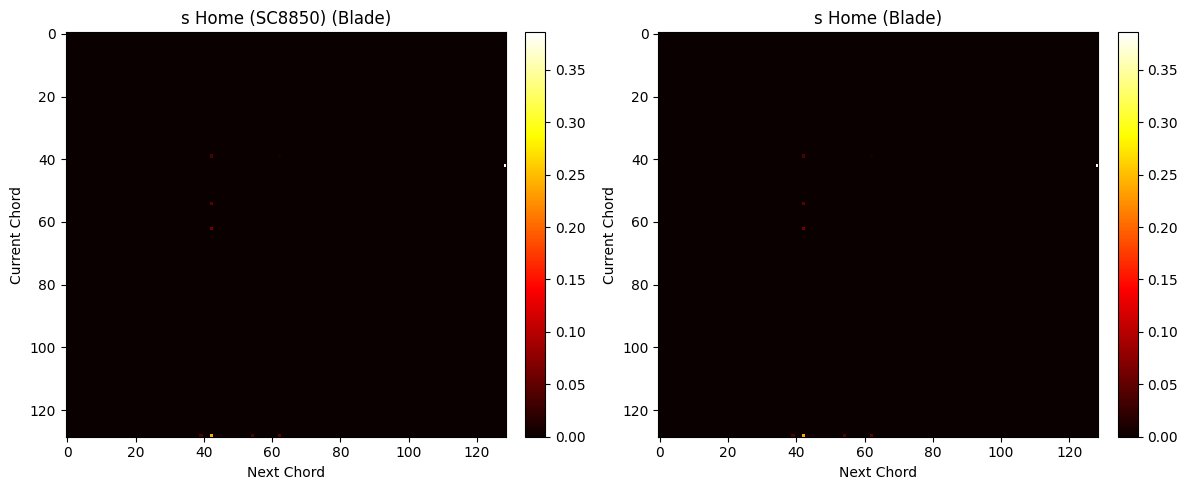

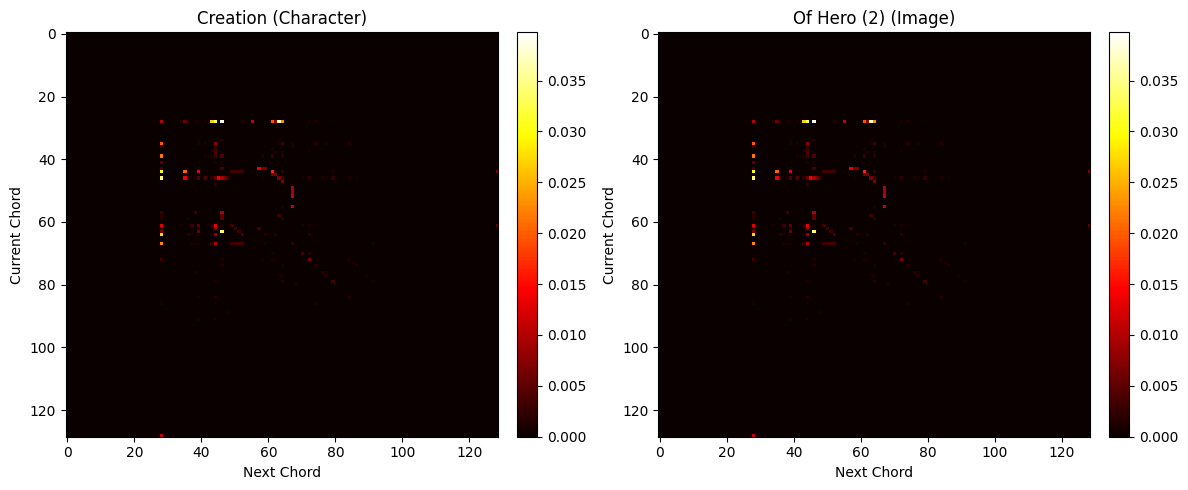


Top 2 least similar songs:


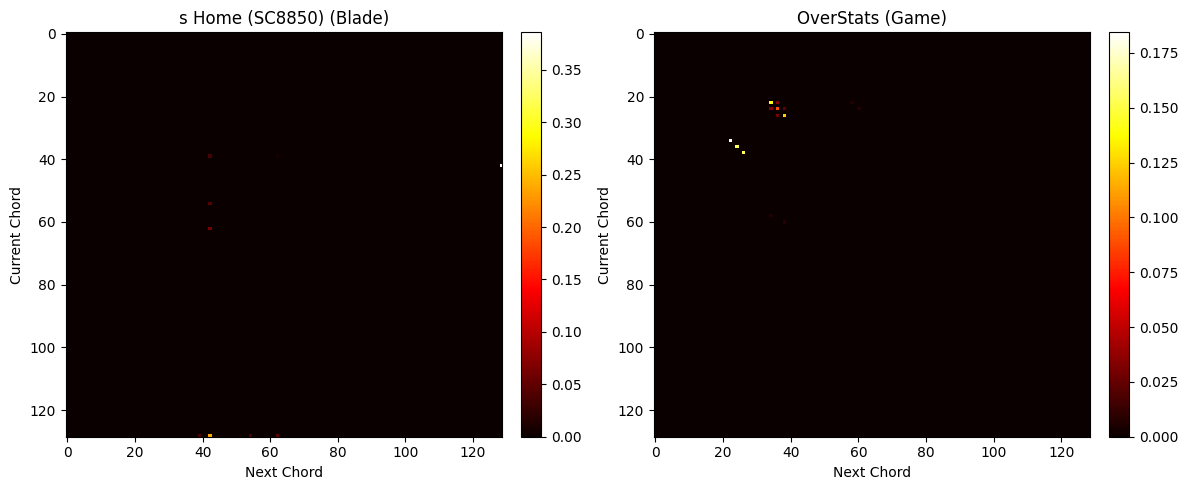

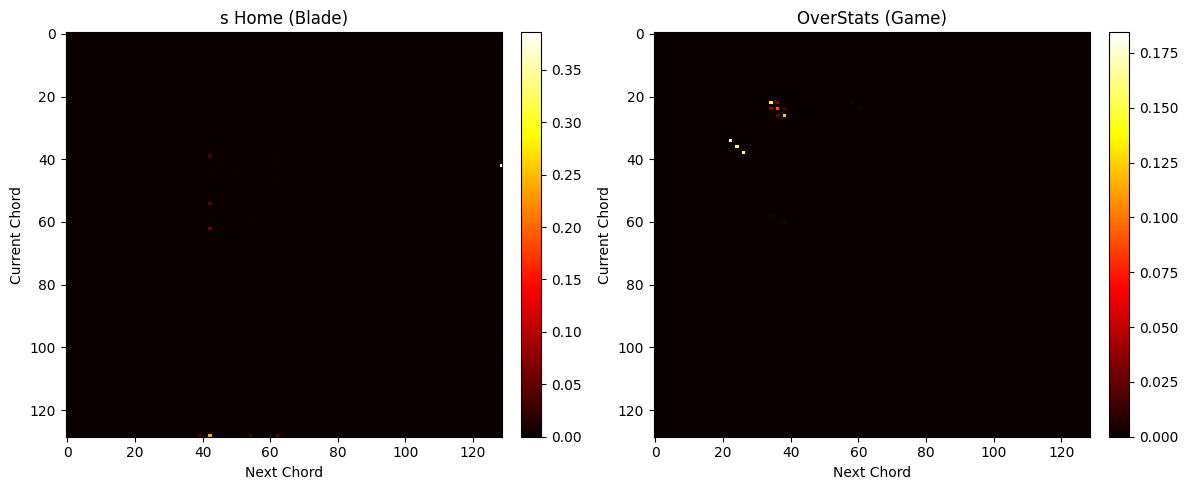

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_top_pairs(distance_matrix, matrices_df, df, top_k=2, most_similar=True):
    """
    Return top_k most similar/dissimilar song pairs formatted as:
    'Song Title (Videogame Name)' along with distance.
    
    Args:
        distance_matrix: np.ndarray, pairwise distances
        matrices_df: DataFrame with 'ctm', index = song_idx
        df: Original Parquet DataFrame with 'name' (song title) and 'videogame' columns
        top_k: int
        most_similar: bool
    
    Returns:
        List of tuples: [(song1_str, song2_str, distance), ...]
    """
    n = distance_matrix.shape[0]
    triu_idx = np.triu_indices(n, k=1)
    pairs = [(i, j, distance_matrix[i, j]) for i, j in zip(*triu_idx)]
    pairs.sort(key=lambda x: x[2], reverse=not most_similar)
    top_pairs = pairs[:top_k]

    formatted = []
    for i, j, dist in top_pairs:
        idx1 = matrices_df.index[i]
        idx2 = matrices_df.index[j]

        song1_name = df.loc[idx1, "name"]
        song2_name = df.loc[idx2, "name"]
        game1_name = df.loc[idx1, "videogame"]
        game2_name = df.loc[idx2, "videogame"]

        formatted.append((
            f"{song1_name} ({game1_name})",
            f"{song2_name} ({game2_name})",
            dist
        ))
    return formatted

def plot_ctms_side_by_side(matrices_df, top_pairs_formatted):
    """
    Plot CTMs side by side for the top similar/dissimilar pairs.
    
    Args:
        matrices_df: DataFrame with 'ctm', index = song_idx
        top_pairs_formatted: list of tuples [(song1_str, song2_str, distance), ...]
    """
    for i, (song1_str, song2_str, dist) in enumerate(top_pairs_formatted):
        idx1 = matrices_df.index[i*2]  # because top_pairs are aligned in order
        idx2 = matrices_df.index[i*2+1]

        M1 = matrices_df.loc[idx1, 'ctm']
        M2 = matrices_df.loc[idx2, 'ctm']

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        for ax, M, title in zip(axes, [M1, M2], [song1_str, song2_str]):
            im = ax.imshow(M, cmap='hot', aspect='auto', interpolation='nearest')
            ax.set_title(title)
            ax.set_xlabel("Next Chord")
            ax.set_ylabel("Current Chord")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

# Example usage
top_similar = get_top_pairs(distance_matrix, matrices_df, df, top_k=2, most_similar=True)
top_dissimilar = get_top_pairs(distance_matrix, matrices_df, df, top_k=2, most_similar=False)

print("Top 2 most similar songs:")
plot_ctms_side_by_side(matrices_df, top_similar)

print("\nTop 2 least similar songs:")
plot_ctms_side_by_side(matrices_df, top_dissimilar)

## Spectral clustering

### Step 1: Distances to similarity

In [ ]:
def distance_to_similarity(D: np.ndarray, sigma: float = None) -> np.ndarray:
    """
    Convert distance matrix D to similarity matrix S using a Gaussian kernel.
    """
    # Heuristic for sigma: median of non-zero distances
    if sigma is None:
        sigma = np.median(distance_matrix[D > 0]) / 2  # or even /3
        print(f"Using sigma = {sigma:.4f}")
    
    S = np.exp(-D**2 / (2 * sigma**2))
    np.fill_diagonal(S, 0)  # no self-similarity links
    return S

sim_matrix = distance_to_similarity(distance_matrix)

Computing KL adjacency (unmasked): 100%|██████████| 504/504 [00:47<00:00, 10.70it/s]


Using sigma = 8.1458


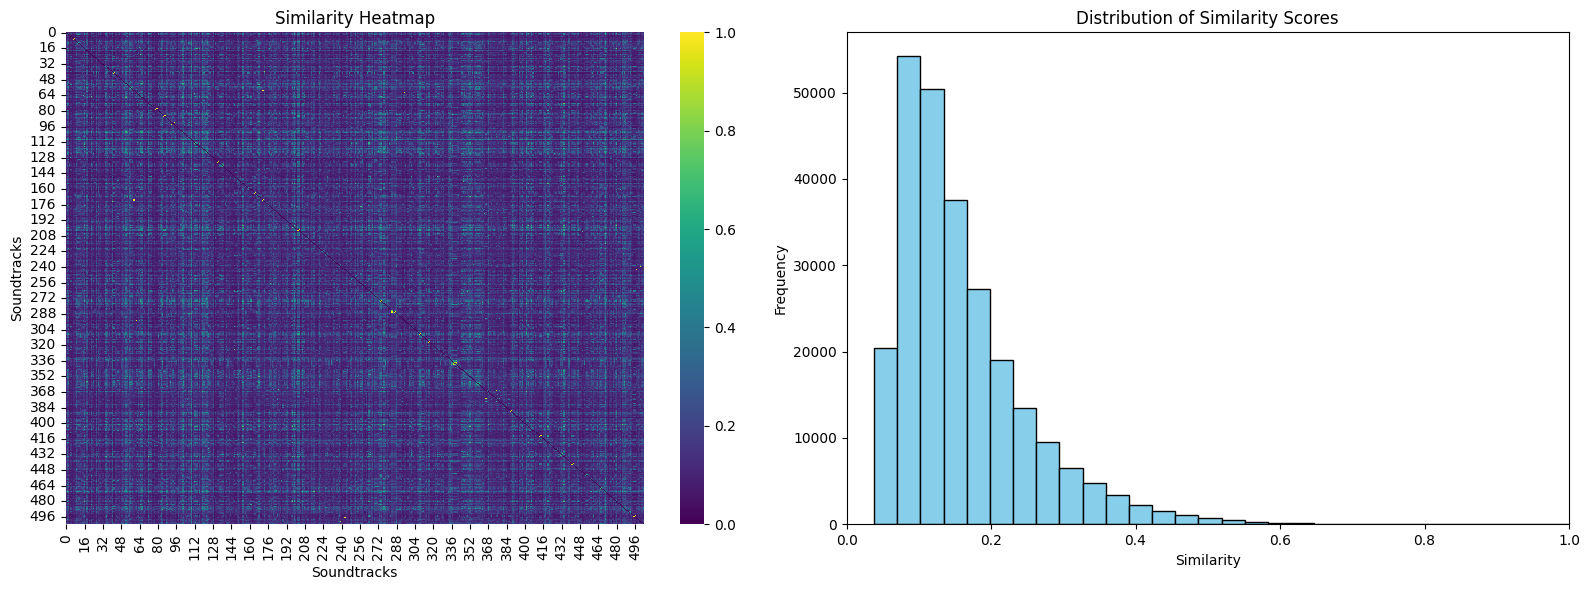

Mean similarity: 0.1600
Standard deviation: 0.0902


In [ ]:
import seaborn as sns

sim_values = sim_matrix[~np.eye(sim_matrix.shape[0], dtype=bool)]

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
sns.heatmap(sim_matrix, cmap="viridis", ax=axes[0])
axes[0].set_title("Similarity Heatmap")
axes[0].set_xlabel("Soundtracks")
axes[0].set_ylabel("Soundtracks")

# Histogram
axes[1].hist(sim_values.flatten(), bins=30, color='skyblue', edgecolor='black')
axes[1].set_title("Distribution of Similarity Scores")
axes[1].set_xlabel("Similarity")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

mean_sim = np.mean(sim_values)
std_sim = np.std(sim_values)

print(f"Mean similarity: {mean_sim:.4f}")
print(f"Standard deviation: {std_sim:.4f}")

### Step 2: Compute the Laplacian

In [ ]:
from scipy.linalg import fractional_matrix_power

D = np.diag(sim_matrix.sum(axis=1))
D_inv_sqrt = fractional_matrix_power(D, -0.5)
L_sym = np.eye(sim_matrix.shape[0]) - D_inv_sqrt @ sim_matrix @ D_inv_sqrt

### Step 3: Take the first $k$ eigenvectors

In [ ]:
from scipy.linalg import eigh
from sklearn.preprocessing import normalize

k = 6  # desired number of clusters
eigvals, eigvecs = eigh(L_sym)

# Take the first k eigenvectors
X = eigvecs[:, :k]

X_norm = normalize(X, norm='l2', axis=1)

### Step 4: Run k-means on the eigenvectors

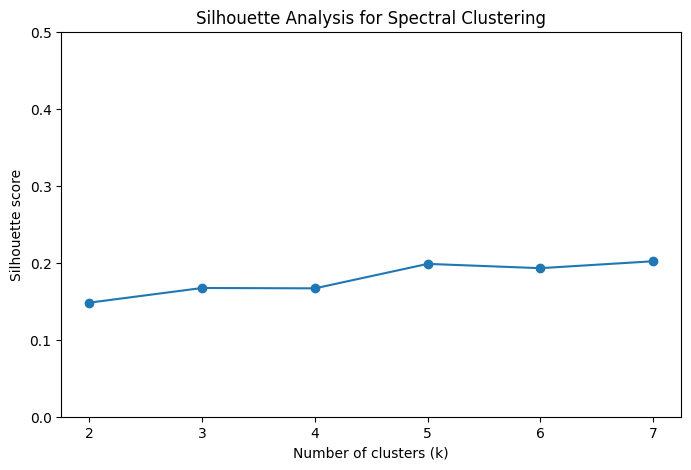

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, k+2)  # test from 2 to k+2 clusters
scores = []

for k_iter in k_values:
    kmeans = KMeans(n_clusters=k_iter, random_state=42)
    labels = kmeans.fit_predict(X_norm)
    score = silhouette_score(X_norm, labels)
    scores.append(score)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(k_values, scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.ylim(0, 0.5)
plt.title("Silhouette Analysis for Spectral Clustering")
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_norm)  # song-level embeddings

matrices_df['cluster'] = labels  # song-level clusters

score = silhouette_score(X_norm, labels)
print(f"Silhouette score for k = {k}: {score:.4f}")

Silhouette score for k = 6: 0.1929


In [ ]:
'''
# -------------------------------
# Videogame-level clustering
# -------------------------------

# Compute mean embedding per videogame
game_embeddings = matrices_df.groupby('id')['matrix'].apply(lambda mats: np.mean(np.stack(mats), axis=0))
X_game = np.stack(game_embeddings.values)  # shape: (#games, features)

k = 6  # number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_game)

# Assign cluster labels to videogames
metadata_df['cluster'] = labels

# Map back to songs if desired
matrices_df['cluster'] = matrices_df['id'].map(metadata_df['cluster'])

# Compute silhouette score at game-level
score = silhouette_score(X_game, labels)
print(f"[Game-level] Fitting KMeans with k = {k}")
print(f"[Game-level] Silhouette score: {score:.4f}")

# Optional: inspect cluster sizes
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
'''

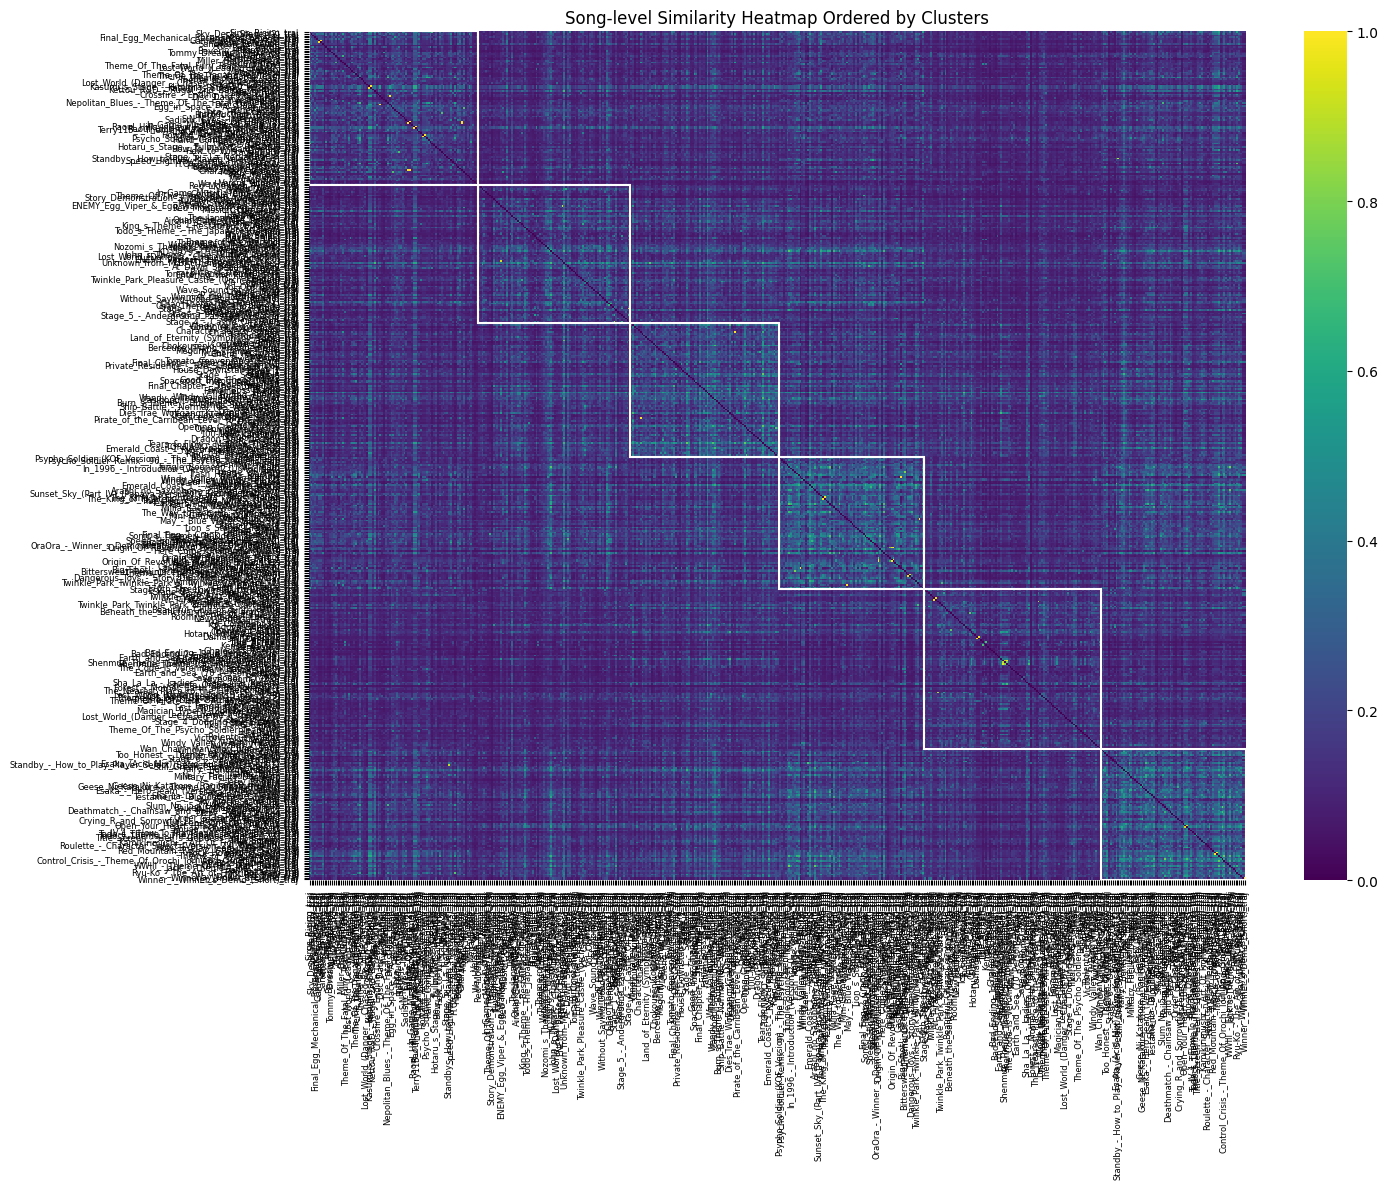

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# matrices_df: song-level DataFrame
# metadata_df: aligned metadata with column "game"
# labels: cluster labels
# sim_matrix: similarity matrix

# Order indices by cluster
order = np.argsort(labels)
sim_ordered = sim_matrix[np.ix_(order, order)]

# Create axis labels: "song_idx — game"
titles_ordered = [
    f"{idx} — {metadata_df.loc[idx, 'game']}"
    for idx in matrices_df.index[order]
]

labels_ordered = labels[order]

# Identify cluster boundaries
boundaries = [0]
current_label = labels_ordered[0]
for i, label in enumerate(labels_ordered):
    if label != current_label:
        boundaries.append(i)
        current_label = label
boundaries.append(len(labels_ordered))

# Plot heatmap
plt.figure(figsize=(15, 12))
ax = sns.heatmap(
    sim_ordered,
    xticklabels=titles_ordered,
    yticklabels=titles_ordered,
    cmap="viridis"
)

plt.title("Song-level Similarity Heatmap Ordered by Clusters")
plt.xticks(rotation=90, fontsize=5)
plt.yticks(rotation=0, fontsize=5)

# Add cluster boxes on diagonal
for i in range(len(boundaries) - 1):
    start = boundaries[i]
    end = boundaries[i + 1]
    size = end - start
    rect = Rectangle(
        (start, start), size, size,
        fill=False, edgecolor='white', linewidth=1.2
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

In [ ]:
for cluster_id in range(k):
    print(f"\nCluster {cluster_id + 1}:")

    # All song indices in this cluster
    song_indices = matrices_df.index[matrices_df['cluster'] == cluster_id]

    # Build labels:  "<song_idx> (<videogame>)"
    cluster_labels = [
        f"{idx} ({metadata_df.loc[idx, 'game']})"
        for idx in song_indices
    ]

    print(cluster_labels)


Cluster 1:
['After the Storm traj', 'All I Want (2) traj', 'Andy Bogard traj', 'Battle Game traj', 'Beginning a Destiny traj', 'Beverly Hills Wharf traj', 'Boss Battle traj', 'Burg Lost traj', 'Chao Theme (v1.2) traj', 'Character Creation traj', 'Cheng Sinzan traj', 'Club Paris traj', 'Crossfire - Ending Credits (v1.1) traj', 'Disc Data Load (XG) traj', 'Disc Data Load traj', 'Egg in Space - A Silver Drop traj', 'Electric Tooth Brush traj', 'Elf Woods traj', 'Final Egg Mechanical Resonance (Type 1) traj', 'Financial Adviser traj', 'Game Selection (XG) traj', 'Game Selection traj', 'Goal! ! traj', 'H.C.C. - New Challenger traj', 'Half-time intermission traj', 'Hand Combat (Dungeon) traj', 'Hardcore Battle traj', 'Heads Or Tails traj', 'Hospital traj', 'Hotaru s Stage - Fullmoon - Heartfull traj', 'How To Play Team Select traj', 'How to Win - Options traj', 'Howard Arena (XG Version) traj', 'Howard Arena traj', 'Image Of Hero (2) traj', 'Image Of Hero (3) traj', 'In-Game Music (Second g

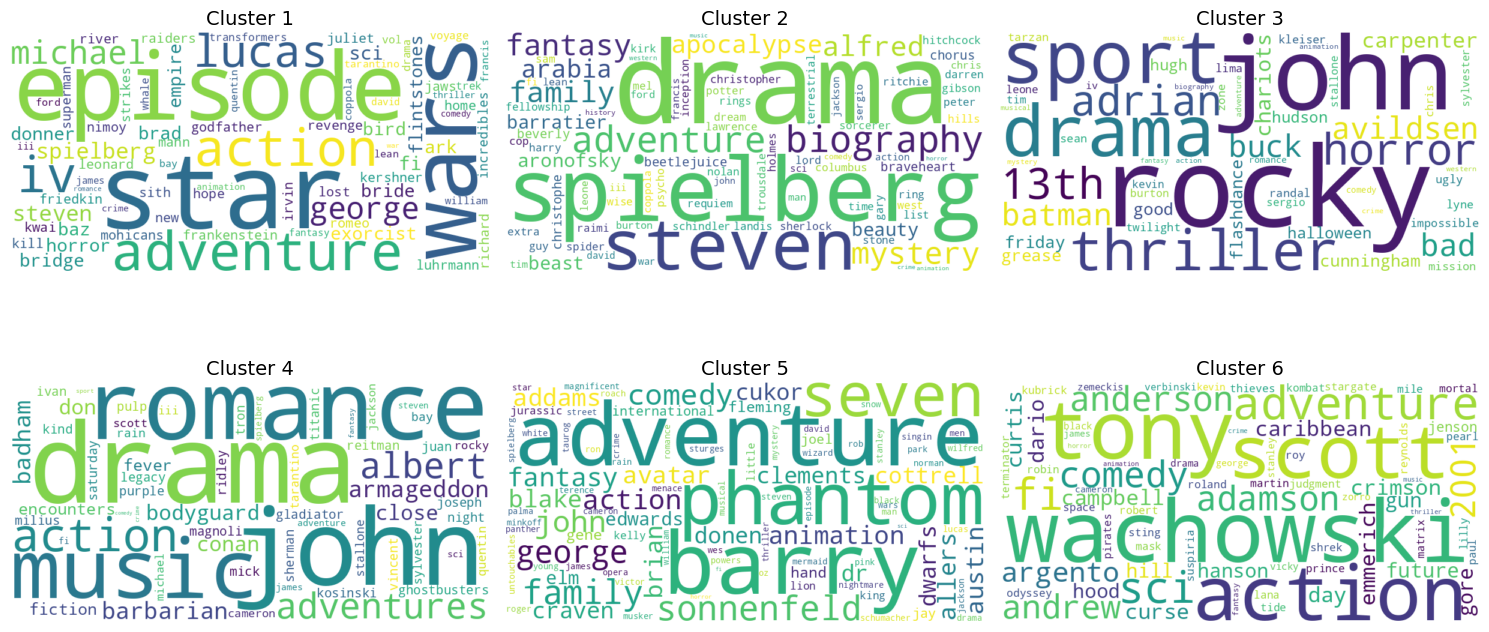

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

# ----------------------------------------------------
# We already have matrices_df and metadata_df from your pipeline.
# metadata_df has the videogame attributes for each song.
# ----------------------------------------------------

# Columns we want to combine into text
possible_text_columns = ['themes', 'keywords', 'involved_companies', 'name', 'summary']
text_columns = [c for c in possible_text_columns if c in metadata_df.columns]

# Combine those fields into a single text field for each song
metadata_df['combined_text'] = metadata_df[text_columns].fillna('').astype(str).agg(' '.join, axis=1)

# Fit TF-IDF vectorizer on the full corpus
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(metadata_df['combined_text'])

# ----------------------------------------------------
# Generate TF-IDF WordCloud for a cluster
# ----------------------------------------------------
def generate_cluster_wordcloud(cluster_id):
    cluster_texts = metadata_df[metadata_df['cluster'] == cluster_id]['combined_text']
    cluster_text = ' '.join(cluster_texts)

    tfidf_vec = vectorizer.transform([cluster_text])
    words = vectorizer.get_feature_names_out()
    scores = tfidf_vec.toarray().flatten()

    # Keep only non-zero scores
    word_scores = {word: score for word, score in zip(words, scores) if score > 0}

    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(word_scores)
    return wc

# ----------------------------------------------------
# Determine cluster layout
# ----------------------------------------------------
cluster_ids = sorted(metadata_df['cluster'].unique())
n_clusters = len(cluster_ids)

n_cols = math.ceil(math.sqrt(n_clusters))
n_rows = math.ceil(n_clusters / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# ----------------------------------------------------
# Plot clouds
# ----------------------------------------------------
for idx, cluster_id in enumerate(cluster_ids):
    wc = generate_cluster_wordcloud(cluster_id)
    axes[idx].imshow(wc, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f"Cluster {cluster_id + 1}", fontsize=14)

# Hide unused plots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()